(C:ssp-traitement)=
# Traitement des signaux bruités

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from myst_nb import glue

plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Détection de signaux

Lorsque l'on parle de « détecter un signal », cela signifie répondre à la question : « le signal est-il présent dans le signal observé $y$ ? ».
Dans cette section, on suppose toujours que le bruit est blanc, gaussien et additif :
par conséquent, le signal observé $y$ est la somme du signal recherché $x$ et d'un bruit $b$.
Différentes techniques de détection existent, en fonction des connaissances que l'on a sur le signal recherché $x$.


### Détection de signaux périodiques inconnus de période inconnue

Dans le cas où l'on cherche dans l'observation un signal $x$ périodique, mais qu'on ne connait ni sa période ni sa forme,
alors l'autocorrélation de $y$ permet de déterminer si le signal est présent et quelle est sa période.
On rappelle que l'autocorrélation revient à mesurer la ressemblance d'un signal avec une version plus ou moins décalée de lui-même.

L'autocorrélation de l'observation $y = x + b$ est :

$$
R_y[m] &= \sum_{n=-\infty}^{+\infty} y[n+m] y[n] \\
       &= \sum_{n=-\infty}^{+\infty} (x[n+m]+b[n+m]) (x[n]+b[n]) \\
       &= R_{x}[m] + R_{xb}[m] + R_{bx}[m] + R_{b}[m]
$$

où :
* $R_{x}$ est l'autocorrélation de $x$, elle est périodique de même période que $x$ ;
* $R_{xb}$ et $R_{bx}$ sont les intercorrélations entre $x$ et $b$ ; elles sont nulles puisque les deux signaux sont décorrélés ;
* $R_{b}$ est l'autocorrélation du bruit $b$ et elle est nulle (sauf en zéro) puisque le bruit est blanc (ses échantillons sont décorrélés).

Finalement, l'autocorrélation $R_y$ est égale à l'autocorrélation de $x$ (sauf en zéro).
Si $x$ est bien présent dans l'observation, alors $R_y$ est périodique et sa période est égale à la période de $x$.

```{glue:figure} G:ssp:detection1
:name: "F:ssp:detection1"

Le signal $y$ est la somme du signal $x$ (périodique, mais de forme et de période inconnues) et d'un bruit blanc $b$.
L'autocorrélation $R_{y}$ fait apparaître un motif périodique de période 50
qui confirme la présence dans $y$ d'un signal de même période.
```


### Détection de signaux périodiques inconnus de période connue

Ce cas est plus favorable que le précédent car on dispose d'une information supplémentaire.
On cherche à déterminer si l'observation $y$ correspond au signal périodique $x$ (de période $T$) bruité par un bruit blanc $b$.
Le principe de détection consiste à effectuer l'intercorrélation de $y$ avec un signal auxiliaire $z$ périodique et de période $T$
(par exemple une simple sinusoïde).

En effet, l'intercorrélation de  $y$ et $z$ est égale à :

$$
R_{yz}[m] &= \sum_{n=-\infty}^{+\infty} y[n+m] z[n] \\
       &= \sum_{n=-\infty}^{+\infty} (x[n+m]+b[n+m]) z[n] \\
       &= R_{xz}[m] + R_{bz}[m].
$$

$R_{xz}$ est périodique puisque $x$ et $z$ sont de même période,
alors que $R_{bz}$ est nulle puisque $b$ et $z$ sont décorrélés.
Ainsi, $R_{yz}$ sera périodique de période $T$ si le signal $x$ est présent.

```{glue:figure} G:ssp:detection2
:name: "F:ssp:detection2"

Le signal observé $y$ est la somme du signal périodique $x$ (de forme inconnue mais de période connue) et d'un bruit blanc $b$.
Le signal auxiliaire $z$ est ici une sinusoïde de même période que $x$.
L'intercorrélation $R_{yz}$ fait apparaître un motif périodique de période 50
qui confirme la présence dans $y$ d'un signal de même période.
```


### Détection d'un motif

Un « motif » est un signal déterministe connu et de durée finie.
La technique suivante permet de déterminer si le motif est présent dans l'observation $y$,
et si oui à obtenir son instant d'apparition.
L'observation est donc modélisée :

$$
y[n] = x[n-k] + b[n]
$$

où $k$ est l'instant d'apparition du motif $x$.

On peut déterminer l'instant $k$ où le motif apparaît en calculant l'intercorrélation entre $y$ et $X$.

Comme l'intercorrélation entre $y$ et $x$ est équivalente à la convolution entre $y$ et le motif $x$ retourné dans le temps ($x[-n]$),
cette technique est un filtrage, qu'on appelle « filtrage adapté » (_matched filter_).
On peut montrer qu'elle est la solution optimale pour maximiser le RSB dans le cadre d'un bruit additif.
Elle est notamment utilisé dans des applications radar ou en communications numériques.

```{glue:figure} G:ssp:filtre-adapte
:name: "F:ssp:filtre-adapte"

Le motif $x$ est une porte et le signal observé $y$ correspond à $x$ décalé de $k=50$ échantillons
et bruité par un bruit blanc gaussien de RSB 20 dB.
Seules les corrélations de $x$ avec $x$ et $y$ présentent un maximum clair,
ce qui indique la présence du motif à cet instant.
```

In [2]:
def myplot(x, y, name, title, ylim, ax):
    
    for side in ['bottom', 'top', 'right', 'left']:
        ax.spines[side].set_color('k')
        ax.spines[side].set_linewidth(0.5)
    ax.grid(linewidth=0.5)
    
    ax.set_xlim( [-200,  200] if name[0]=="R" else [   0, 200] )
    ax.set_ylim( ylim if name[0]=="R" else [-2.5, 2.5] )
    
    plt.plot(x, y, 'tab:blue')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=16)

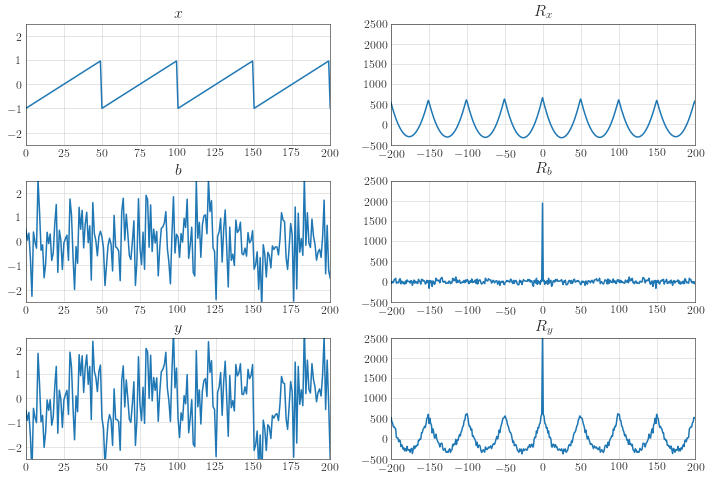

In [3]:
# Détection d'un signal périodique de période inconnue

N = 2000
n = np.arange(N)
m = np.arange(-N, N-1)

# Signal non bruité
x = signal.sawtooth(2*np.pi*n*0.02)
Rx = np.correlate(x, x, "full")

# Bruit
b = np.random.normal(0, 1, N)
Rb = np.correlate(b, b, "full")

# Signal bruité
y = x + b
Ry = np.correlate(y, y, "full")

# Affichage
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(3,2,1)
myplot(n, x, "x", "$x$", [], ax)
ax = plt.subplot(3,2,2)
myplot(m, Rx, "Rx", "$R_x$", [-500, 2500], ax)
ax = plt.subplot(3,2,3)
myplot(n, b, "b", "$b$", [], ax)
ax = plt.subplot(3,2,4)
myplot(m, Rb, "Rb", "$R_b$", [-500, 2500], ax)
ax = plt.subplot(3,2,5)
myplot(n, y, "y", "$y$", [], ax)
ax = plt.subplot(3,2,6)
myplot(m, Ry, "Ry", "$R_y$", [-500, 2500], ax)
plt.subplots_adjust(hspace=0.3)
glue("G:ssp:detection1", fig, display=False)

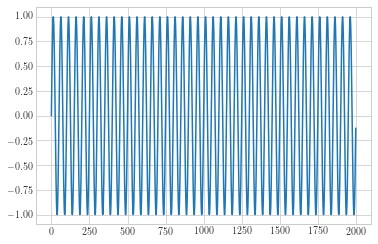

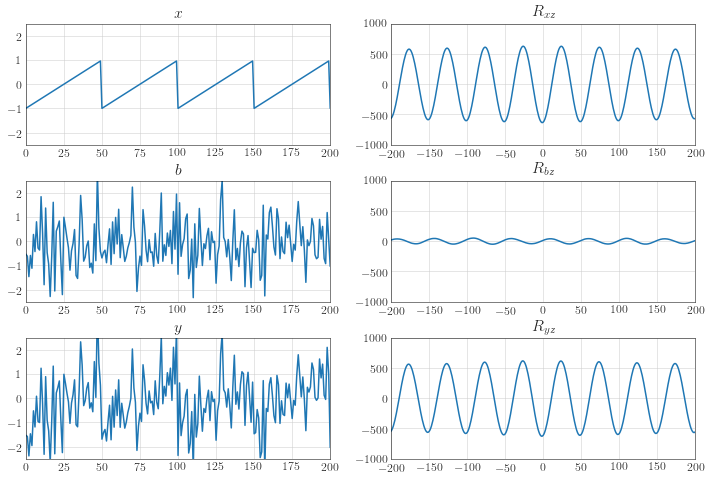

In [4]:
# Détection d'un signal périodique de période connue

N = 2000
n = np.arange(N)
m = np.arange(-N, N-1)

# Signal non bruité
x = signal.sawtooth(2*np.pi*n*0.02)

# Signal auxiliaire
z = np.sin(2*np.pi*n*0.02)
plt.figure
plt.plot(n,z)

# Bruit
b = np.random.normal(0, 1, N)

# Signal bruité
y = x + b

# Intercorrélations
Rxz = np.correlate(x, z, "full")
Rbz = np.correlate(b, z, "full")
Ryz = np.correlate(y, z, "full")

# Affichage
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(3,2,1)
myplot(n, x, "x", "$x$", [], ax)
ax = plt.subplot(3,2,2)
myplot(m, Rxz, "Rxz", "$R_{xz}$", [-1000, 1000], ax)
ax = plt.subplot(3,2,3)
myplot(n, b, "b", "$b$", [], ax)
ax = plt.subplot(3,2,4)
myplot(m, Rbz, "Rbz", "$R_{bz}$", [-1000, 1000], ax)
ax = plt.subplot(3,2,5)
myplot(n, y, "y", "$y$", [], ax)
ax = plt.subplot(3,2,6)
myplot(m, Ryz, "Ryz", "$R_{yz}$", [-1000, 1000], ax)
plt.subplots_adjust(hspace=0.3)
glue("G:ssp:detection2", fig, display=False)

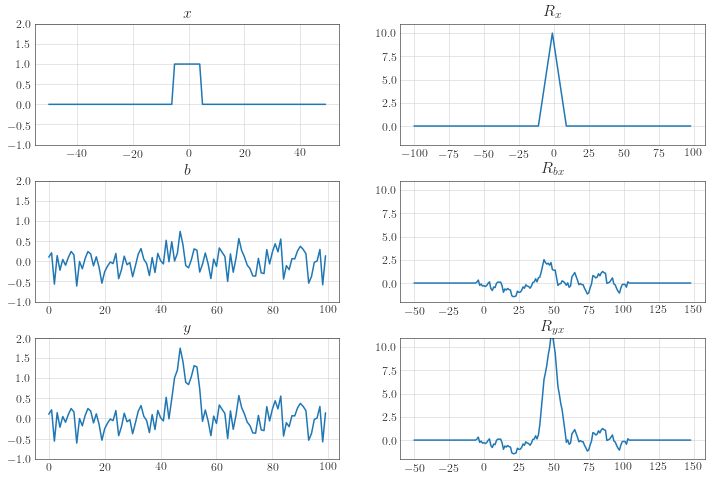

In [5]:
# Exemple de filtre adapté

def addplot(x, y, title, ylim):
    
    # Nouveau subplot
    spi = len(fig.get_axes()) + 1
    ax = plt.subplot(3, 2, spi)
    
    # Bordure en noir + grille
    for side in ['bottom', 'top', 'right', 'left']:
        ax.spines[side].set_color('k')
        ax.spines[side].set_linewidth(0.5)
    ax.grid(linewidth=0.5)
    
    # Signal
    plt.plot(x, y, 'tab:blue')
    ax.set_ylim(ylim)
    
    # Taille de police
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=16)


N = 100
nx = np.arange(-N/2, N/2)
n = np.arange(0, N)
mx = np.arange(-N, N-1)
m = np.arange(50-N, 50+N-1)

# Motif
x = np.concatenate([np.zeros(45), np.ones(10), np.zeros(45)])

# Bruit
rsb = 20
Px = np.linalg.norm(x)**2
sig = np.sqrt( Px * 10**(-rsb/10) )
b = np.random.randn(N)*sig

# Observation
y = x + b

# Intercorrélations
Rxx = np.correlate(x, x, "full")
Rbx = np.correlate(b, x, "full")
Ryx = np.correlate(y, x, "full")

# Affichage
fig = plt.figure(figsize=(12, 8))
addplot(nx, x,   "$x$",      ylim=[-1, 2])
addplot(mx, Rxx, "$R_{x}$",  ylim=[-2, 11])
addplot(n,  b,   "$b$",      ylim=[-1, 2])
addplot(m,  Rbx, "$R_{bx}$", ylim=[-2, 11])
addplot(n,  y,   "$y$",      ylim=[-1, 2])
addplot(m,  Ryx, "$R_{yx}$", ylim=[-2, 11])
plt.subplots_adjust(hspace=0.3)
glue("G:ssp:filtre-adapte", fig, display=False)

## Débruitage de signaux

Débruiter un signal, c'est réduire le plus possible le bruit présent dans le signal.
Sauf cas très particulier, il n'est pas possible d'éliminer complètement le bruit puisqu'il est inconnu.


### Débruitage d'un signal unique

On observe un signal $x$ bruité par un bruit blanc gaussien additif :

$$
\forall n, \quad y[n] = x[n] + b[n].
$$

Pour réduire le bruit dans le signal, on peut remplacer chaque échantillon $y[n]$
par la moyenne des $M$ échantillons autour de $n$.
On obtient alors un nouveau signal $z$ :

$$
\forall n, \quad z[n] = \frac{1}{M} \sum_{m=n-\frac{M-1}{2}}^{n+\frac{M-1}{2}} y[m]
$$

où $M$ est impair.

<div class="example">
    
Si le signal observé est :
    
$$
y = [4,\, 9,\, 8,\, 7,\, 12,\, 5,\, 1,\, 0,\, 5,\, 4,\, 3,\, 2,\, 4]
$$

alors le calcul de la moyenne de $M=3$ échantillons autour de chaque échantillons de $y$ donne :
    
$$
z = [?,\, 7,\, 8,\, 9,\, 8,\, 6,\, 2,\, 2,\, 3,\, 4,\, 3,\, 3,\, ?]
$$

où les deux points d'interrogation correspondent à des échantillons qu'on ne peut pas calculer.

La {numref}`F:ssp:filtre-moyenneur-exemple` représente ces deux signaux.
    
```{glue:figure} G:ssp:filtre-moyenneur-exemple
:name: "F:ssp:filtre-moyenneur-exemple"

Signaux $y$ (en bleu) et $z$ (en orange).
```
</div>

On peut montrer que cette technique peut s'écrire sous la forme d'une convolution :
c'est donc un filtrage appelé « filtre moyenneur ».
La réponse impulsionnelle de ce filtre et une porte de longueur $M$,
dont la transformée de Fourier à temps discret est un sinus cardinal.
Ainsi, le filtre moyenneur est un filtre passe-bas.
Il atténue les fréquences élevées présentes dans le bruit.

```{glue:figure} G:ssp:filtre-moyenneur
:name: "F:ssp:filtre-moyenneur"

Le signal observé $y$ est la somme du signal d'intérêt $x$ et d'un bruit.
Le filtre moyenneur effectue une moyenne glissante pour remplacer chaque échantillon du signal observé
par la moyenne des $M$ échantillons voisins.
Plus le nombre d'échantillons moyennés $M$ est grand, plus le bruit sera atténué.
Mais la forme du signal d'intérêt $x$ sera lissée.
```

### Débruitage de plusieurs réalisations d'un même signal

Dans le cas où l'on dispose de $I$ mesures d'un même signal $x$ :

$$
\forall i, n, \quad y_i[n] = x[n] + b_i[n]
$$

et que le bruit est centré ($\mathbb{E}[b_i]=0$), alors la moyenne des $y_i$ permet d'augmenter le RSB
d'un facteur $10\log(I)$.

```{glue:figure} G:ssp:moyennage
:name: "F:ssp:moyennage"

Le moyennage de plusieurs réalisations $y_i$ d'un même signal $x$ permet de réduire le niveau de bruit (et donc le RSB).
Plus il y a de signaux moyennés, meilleur sera le débruitage, ainsi que le montre le RSB.
Le premier graphe ci-dessous représente 50 réalisations superposées (en gris),
l'une d'elle est en bleu pour être visible.
```

[ 4  9  8  7 12  5  1  0  5  4  3  2  4]
[7. 8. 9. 8. 6. 2. 2. 3. 4. 3. 3.]


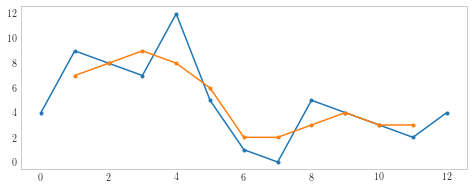

In [6]:
# Données
y = np.array([4, 9, 8, 7, 12, 5, 1, 0, 5, 4, 3, 2, 4])
M = len(y)
m = np.arange(M)

# Filtre moyenneur
N = 3
h = np.ones(N)/N
z = np.convolve(y, h, mode="valid")

print(y)
print(z)

fig = plt.figure(figsize=(8,3))
plt.plot(m, y, ".-")
plt.plot(m[1:-1], z, ".-")
plt.grid()

glue("G:ssp:filtre-moyenneur-exemple", fig, display=False)

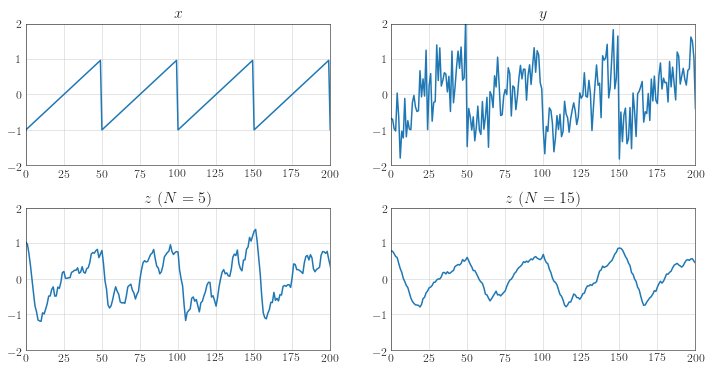

In [7]:
# Filtre moyenneur

def addplot(x, y, title):
    
    # Nouveau subplot
    spi = len(fig.get_axes()) + 1
    ax = plt.subplot(2, 2, spi)
    
    # Bordure en noir + grille
    for side in ['bottom', 'top', 'right', 'left']:
        ax.spines[side].set_color('k')
        ax.spines[side].set_linewidth(0.5)
    ax.grid(linewidth=0.5)
    
    # Signal
    plt.plot(x, y, 'tab:blue')
    ax.set_xlim([0, 200])
    ax.set_ylim([-2, 2])
    
    # Taille de police
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=16)

    
# Signal bruité
N = 2000
n = np.arange(0, N)
x = signal.sawtooth(2*np.pi*n*0.02)
b = np.random.normal(0, 0.5, N)
y = x + b

# Affichage
fig = plt.figure(figsize=(12, 6))
addplot(n, x, "$x$")
addplot(n, y, "$y$")

# Application du filtre moyenneur
for M in [5, 15]:
    
    # Réponse impulsionnelle
    h = np.concatenate([np.ones(M), np.zeros(N-M)]) / M
    
    # Signal débruité
    z = np.convolve(y, h, 'same')
    
    # Affichage
    addplot(n, z, f"$z$ ($N={M}$)")

plt.subplots_adjust(hspace=0.3)
glue("G:ssp:filtre-moyenneur", fig, display=False)

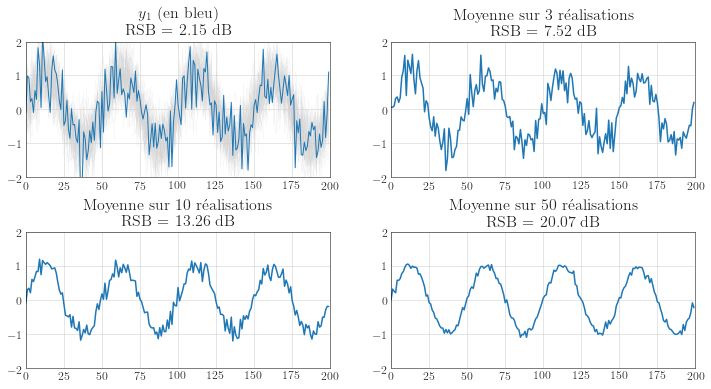

In [8]:
# Moyennage de plusieurs signaux

def addplot(x, y, rsb, title):
    
    # Nouveau subplot
    spi = len(fig.get_axes()) + 1
    ax = plt.subplot(2, 2, spi)
    
    # Bordure en noir + grille
    for side in ['bottom', 'top', 'right', 'left']:
        ax.spines[side].set_color('k')
        ax.spines[side].set_linewidth(0.5)
    ax.grid(linewidth=0.5)
    
    # Signal
    if spi==1:
        for k in range(1,y.shape[0]):
            plt.plot(x, y[k,:], 'lightgray', linewidth=0.1)
        plt.plot(x, y[0,:], 'tab:blue', linewidth=1)
    else:
        plt.plot(x, y, 'tab:blue')
    ax.set_xlim([0, 200])
    ax.set_ylim([-2, 2])
    
    # Taille de police
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title + '\nRSB = {:.2f} dB'.format(rsb), fontsize=16)

# K signaux bruités
K = 50
N = 200
n = np.arange(0, N)
x = np.sin(2*np.pi*n*0.02)
Px = np.linalg.norm(x)**2/N
y = np.zeros((K,N))
for k in range(K):
    yk = x + np.random.normal(0, 0.5, N)
    y[k,:] = yk
    
# RSB
b = y[0,:] - x
Pb = np.linalg.norm(b)**2/N
rsb = 10 * np.log10(Px/Pb)

# Affichage
fig = plt.figure(figsize=(12, 6))
addplot(n, y, rsb, "$y_1$ (en bleu)")

# Moyennage
for L in [3, 10, 50]:
    
    # Moyennage
    z = np.mean(y[0:L,:], axis=0)
    
    # RSB
    b = z - x
    Pb = np.linalg.norm(b)**2/N
    rsb = 10 * np.log10(Px/Pb)
    
    # Affichage
    addplot(n, z, rsb, f"Moyenne sur {L} réalisations")

plt.subplots_adjust(hspace=0.4)
glue("G:ssp:moyennage", fig, display=False)

## Approximation par moindres carrés

<!-- Gauss 1795 -->

On dispose de données $y$ qui correspondent à un signal $x=f(\theta)$ bruité :

$$
y[n] = f_{\theta}[n] + b[n]
$$

où :
* $f_{\theta}$ est une fonction paramétrique (sinusoïde, polynôme, etc.) connue,
* $\theta$ est un ensemble de paramètres $\theta=(\theta_1, \theta_2, \dots)$ inconnus,
* $f_{\theta}[n]$ est la valeur de la fonction $f$ paramétrée par $\theta$ en $n$,
* $b$ est un bruit de moyenne nulle.

Par exemple, si $f$ est un polynôme d'ordre 2, alors $f_{\theta}[n] = \theta_1 + \theta_2 n + \theta_3 n^2$.
Si $f$ est une exponentielle, alors $f_{\theta}[n] = \theta_1 \exp(\theta_2 n)$.

L'objectif est de retrouver $\theta$ à partir de $y$.
Il est logique de choisir $\theta$ comme la paramètre qui minimise les différences entre $y$ et $f_{\theta}$.
Mathématiquement, il faut donc minimiser

$$
\sum_{n=1}^N \left(y[n] - f_{\theta}[n]\right)^2.
$$

La parenthèse, qui exprime la différence entre $y$ et $f_{\theta}$ en chaque échantillon $n$,
est mise au carré car les calculs sont plus simples à effectuer qu'avec une valeur absolue.
On cherche donc à minimiser les différences au carrés, d'où le nom de la méthode.

Cette différence, qui dépend de $\theta$ est notée comme la fonction

$$
\mathcal{J}(\theta) = \sum_{n=1}^N \left(y[n] - f_{\theta}[n]\right)^2.
$$

Remarquez que $\mathcal{J}(\theta)$ revient à la norme au carré de $y - f_{\theta}$ !

```{margin}
Si $f$ n'est pas linéaire, alors il faut utiliser une méthode de moindres carrés non linéaires.
```

Nous nous concentrons dans cette section sur les fonctions $f$ linéaires en $\theta$
(par exemple si $f$ est un polynôme), car trouver les valeurs de $\theta$ qui minimisent $\mathcal{J}$ est simple
et aboutit à une expression explicite de $\theta$.
On peut donc écrire $f$ sous la forme :

$$
\forall n, \quad f_{\theta}[n] = \theta_1 h_{1n} + \theta_1 h_{2n} + \dots + \theta_M h_{Mn}.
$$

Dans la suite, les calculs sont effectués avec la représentation vectorielle.
On a donc :

$$
y = \begin{bmatrix} y_1 \\ \vdots \\ y_N \end{bmatrix}
\qquad\text{et}\qquad
f_\theta = H\theta
         = \begin{bmatrix} h_{11} & \dots & h_{1M} \\ \vdots & & \vdots \\ h_{N1} & \dots & h_{NM} \end{bmatrix}
           \begin{bmatrix} \theta_1 \\ \vdots \\ \theta_M \end{bmatrix}.
$$

Avec ces notations, $\mathcal{J}(\theta)$ s'écrit :

$$
\mathcal{J}(\theta)
&= \|y-H\theta\|^2 \\
&= (y-H\theta)^T(y-H\theta) \\
&= y^Ty - y^TH\theta - \theta^TH^Ty + \theta^TH^TH\theta
$$

Trouver la valeur de $\theta$ qui minimise $\mathcal{J}(\theta)$
revient à trouver la valeur qui annule la dérivée de $\mathcal{J}(\theta)$ :

$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta} = - 2H^Ty + 2H^TH\theta
$$

Et donc :

$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta} = 0
\qquad\Leftrightarrow\qquad
2H^Ty = 2H^TH\theta
\qquad\Leftrightarrow\qquad
\theta = (H^TH)^{-1} H^Ty.
$$

Cette dernière équation définit donc la valeur de $\theta$ qui minimise l'erreur des moindres carrés,
c'est donc la valeur de $\theta$ qui permet d'avoir une fonction $f_{\theta}$ qui approxime au mieux les données $y$.

```{glue:figure} G:ssp:moindres-carres
:name: "F:ssp:moindres-carres"

Les données $y$ sont approximées par un polynôme d'ordre 3 avec la méthode des moindres carrés.
Le résultat est comparé avec un filtre moyenneur de taille 20, qui donne une estimation moins « propre ».
Les données non bruitées (que l'on cherche donc à retrouver) sont tracées en gris.
```

```{glue:figure} G:ssp:moindres-carres-differences
:name: "F:ssp:moindres-carres-differences"

Mise en évidence des erreurs à minimiser.
```


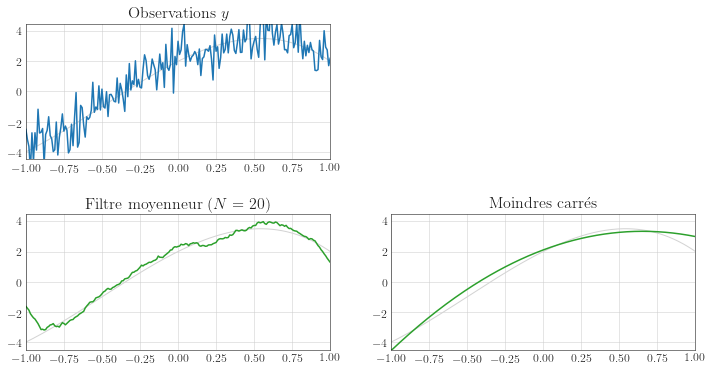

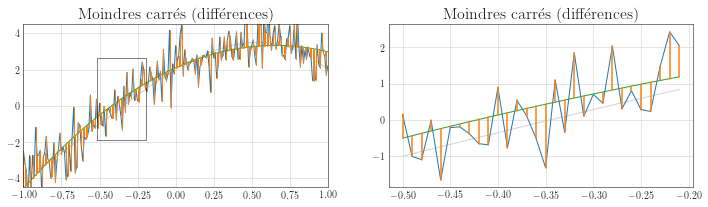

In [56]:
# Approximation par moindres carrés

def addplot(x, y, gt, title):
    
    # Nouveau subplot
    if len(fig.get_axes())==0:
        spi = 1
    else:
        spi = len(fig.get_axes()) + 2
    ax = plt.subplot(2, 2, spi)
    
    # Bordure en noir + grille
    for side in ['bottom', 'top', 'right', 'left']:
        ax.spines[side].set_color('k')
        ax.spines[side].set_linewidth(0.5)
    ax.grid(linewidth=0.5)
    
    # Signal
    plt.plot(x, gt, 'lightgray', linewidth=1)
    plt.plot(x, y, 'tab:blue' if spi==1 else 'tab:green')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-4.5, 4.5])
    
    # Taille de police
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=16)

# Polynôme bruité
N = 201
n = np.linspace(-1, 1, N)
x = 2 + 5*n - 3*n**2 - 2*n**3
b = np.random.normal(0, 1, N)
y = x + b
# myplot(n, x, '$x$', 'x')

# Filtre moyenneur
M = 20
L = (int)((N/M)/2)
h = np.concatenate([ np.zeros(L), np.ones(M), np.zeros(L)]) / M
z = np.convolve(y, h, 'same')

# Moindres carrés
H = np.vstack([ n**0, n*1, n**2, n**2 ]).T
c = np.linalg.lstsq(H, y, rcond=None)[0]
w = np.dot(H,c)

# Affichage
fig = plt.figure(figsize=(12, 6))
addplot(n, y, x, 'Observations $y$')
addplot(n, z, x, 'Filtre moyenneur ($N=' + str(M) + '$)')
addplot(n, w, x, 'Moindres carrés')
plt.subplots_adjust(hspace=0.4)
glue("G:ssp:moindres-carres", fig, display=False)

# Affichage des différences
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
for spi in range(2):
    if spi==0:
        idx = range(len(n))
    else:
        idx = range(50, 80)
    for side in ['bottom', 'top', 'right', 'left']:
        ax[spi].spines[side].set_color('k')
        ax[spi].spines[side].set_linewidth(0.5)
    ax[spi].grid(linewidth=0.5)
    ax[spi].plot(n[idx], x[idx], 'lightgray', linewidth=1)
    ax[spi].plot(n[idx], y[idx], 'tab:blue', linewidth=1)
    ax[spi].plot(n[idx], w[idx], 'tab:green', linewidth=1)
    if spi==0:
        ax[spi].plot([n[idx], n[idx]], [w[idx], y[idx]], 'tab:orange', linewidth=1)
    else:
        ax[spi].plot([n[idx], n[idx]], [w[idx], y[idx]], 'tab:orange')
    if spi==0:
        ax[spi].set_xlim([-1, 1])
        ax[spi].set_ylim([-4.5, 4.5])
#     ax[spi].set_xticks(fontsize=12)
#     ax[spi].set_yticks(fontsize=12)
    ax[spi].set_title("Moindres carrés (différences)", fontsize=16)
    
co = ax[1].axis()
ax[0].plot([co[0], co[1], co[1], co[0], co[0]], [co[2], co[2], co[3], co[3], co[2]], "k", linewidth=0.5)
glue("G:ssp:moindres-carres-differences", fig, display=False)